# Dynamic Systems

All physical systems that store and transform energy are all dynamic systems that cannot react instantaneously
to an external solicitation. This because if an energy transformation were to be instantaneous, it would require
an infinite power ($P=dW/dt$), which is impossible to deliver.

These systems are characterized by their capacity to act or not in a stable way, in a fast way, in an oscillating
way, ...

When the underlying physics of dynamic systems is sufficiently known, we have mathematical models capable
of describing their temporal behavior: differential equations. Matlab allows the integration of linear differential
equations with constant coefficients (LTI: Linear Time Invariant), expressed in different forms (and thus their
numerical solutions), but also of non-linear differential equations (for which the most appropriate simulation tool
is Simulink but it will not be discussed here).

As an illustration, let's take the following example: if a force applied to a mass is at the origin of an acceleration,
it is by integrating this force (divided by the mass) that we will obtain the velocity as a function of time and, by
integrating the velocity, we will obtain the distance traveled. So we express the derivatives, Matlab integrates
them. That's easy!

We will continue this tutorial with this well known example: the system mass ($M$), spring ($K$), damper ($R_f$), of
position $y$, subjected to an external force $u$.

![](./12_image1.png)

with $M = 0.5 kg$; $R_f=0.2kg/s$ and $K=1kg/s^2$

The first step in the analysis of a physical system is to write down the laws of physics that govern its operation.

Here, the dynamic equilibrium equation of the forces ($\sum_i F_i = M \cdot a$) on the mass $M$ is writen : $M \frac{d^2y}{dt} + R_f \frac{dy}{dt} + Ky = u$ or in a normalized way : $\frac{d^2y}{dt^2} + \frac{R_f}{M}\frac{dy}{dt} + \frac{K}{M}y = \frac{1}{M}u$

Recall that this differential equation can, **only because it is an LTI equation**, be transformed into a polynomial expression as a function of the variable "$s$" by passing in the Laplace domain.

This passage in the Laplace domain is done with the Laplace transform, and allows us :

- to make our life much easier : we will manipulate algebraic equations rather than differential equations
- to quickly judge the dynamics and stability of the system by identifying its poles (the roots of the
denominator)
- to obtain directly the harmonic response of the system, i.e. in sinusoidal regime after the transient phase,
by replacing "$s$" by "$j\omega$".

Our differential equation becomes, by the Laplace transform : $s^2Y(s) + \frac{R_f}{M}sY(s) + \frac{K}{M}Y(s) = \frac{1}{M}U(s)$

The transfer function is the ratio of the output y to the input u : $$H(s) = \frac{Y(s)}{U(s)} = \frac{\frac{1}{M}}{s^2 + \frac{R_f}{M}s + \frac{K}{M}}$$

This transfer function $H(s)$ will serve as an illustrative example throughout this tutorial. As soon as we talk about the $H(s)$ system, it will be good to remember that the physics behind this transfer function is this mass-spring-damper system.

*NB: If the equation relating to this system were a non-linear differential equation, it would be necessary to work with the tools that are briefly presented at the end of this tutorial, or else it would be necessary to accept to work with small variations of the quantities around an operating point of this system to be able to apply the Laplace transform. This amounts to linearizing this system and allows to use all the theory related to transfer functions. This linearization approach is the one most frequently encountered in industry. Let's remember that the most frequent objective in industry is to control a system with a controller. And it turns out that the LTI tools allowing the implementation of this control are much more understandable and simple to implement than the non linear techniques, which explains why these solutions are preferred.*

## Transfer functions creation (continuous or discrete) in Python

Python knows the "$s$" (for the continuous systems) and "$z$" (for the discrete ones) variables. We can therefore create the transfer function as a fraction of polynomials of "$s$".

But first, the "$s$" variable should be created, which is done with the instruction `tf` from the `control` module:

In [1]:
import control as ct

s=ct.tf('s')

This variable (Laplace variable) can then be manipulated to write the polynomials of the transfer functions. In the case of the above example, by replacing the parameters by their values, this gives :

In [2]:
assert s is not None  # to please the type checker
H = 2/(s**2+0.4*s+2)
H # to make jupyter display the transfer function

TransferFunction(array([2]), array([1. , 0.4, 2. ]))

Note that the instruction `tf` can be used in another way, without creating the variable $s$, by giving it the coefficients of the polynomials in $s$: `ct.tf(num,den)` where `num` is the polynomial of the coefficients in $s$ of the numerator and `den` that of the denominator.

It is also possible to create a transfer function in Python by providing the zeros, the poles and the gain, via the instruction `ct.zpk`.

These ways of doing things being less intuitive, we will prefer the method based on the creation of the variable $s$, and refer you to the `control` module help for the rest.

In the same way, we can create a transfer function not in continuous but in discrete, by creating beforehand the variable $z$, as well as the sampling time `Ts` of application. Unlike Matlab, in Python you must use the `ct.tf(num, den, Ts)` form to create a discrete-time transfer function. To create the $z$ variable, choose the `num` and `den` so that the transfer function simplifies to $z$:

$$z = \frac{1z + 0}{1}$$

In [3]:
Ts = 0.1 # this is the sampling time, expressed in seconds
z = ct.tf([1, 0], [1], Ts) 
z

TransferFunction(array([1, 0]), array([1]), 0.1)

In [4]:
assert z is not None
Hz=2/(z**2+0.4*z+2)  # Discrete transfer function, with the sample time
                     # (Ts) = 0.1s, as the "z" variable was created specifying
                     # this value
Hz

TransferFunction(array([2]), array([1. , 0.4, 2. ]), 0.1)

**Pay attention**, it is important to note that the transfer function `Hz` created above is not the equivalent of the transfer function `H` in discrete, even if the numerator and denominator are identical!

To discretize the system `H` and obtain the discrete version, we can use the "continue to discrete" command, specifying the continuous system to be discretized and the sampling period Ts : `Sysd = ct.c2d(Sysc,Ts)`.

By default, the discretization method used is that of the zero-order blocker:

In [5]:
Hz = ct.c2d(H, Ts) # We get a discrete transfert function (using the z variable).
                   # The polynomials (numerator and denominator) are different from
                   # the ones we had in continuous H.
Hz

TransferFunction(array([0.0098516 , 0.00972103]), array([ 1.        , -1.94121681,  0.96078944]), 0.1)

We can see here that the global order of `Hz` is $z^{-1}$, which expresses well that the influence of the input on the output will be perceived only after a sampling time.

## Finding and plotting a transfer function poles and zeros

As already mentioned, the poles of this transfer function correspond to the roots of the denominator (which can be real or complex conjugates), and characterize the dynamics of the system and its stability. Indeed, when we use the inverse Laplace transform to return to the time domain, the answer we obtain will be a sum of exponentials defined by the position of the poles in the Laplace domain:

- The real part of the poles will define the speed of decay or growth of the exponential : $e^{t \cdot p_r}$ with $p_r$ being the real part of the pole : One can understand that poles with a positive real part will give rise to increasing exponentials, and thus to a system which will not converge and will be unstable. **A system will be stable if all its poles are located to the left of the imaginary axis in the complex plane**. One can also observe that $e^{t \cdot p_r}$ can be classically written $e^{\frac{t}{\tau}}$ when dealing with differential equations, and that therefore the real part of a pole is the inverse of its time constant : the further the pole is from the imaginary
axis, the faster the associated time constant will be, and the less its influence on the transient will be important. Conversely, a pole close to the imaginary axis will be considered as a dominant pole.
- The imaginary part of the poles will lead in the time domain to a complex exponential, or a sinusoid. This implies that **if there are complex poles conjugated in the complex plane, it will lead us to have an oscillating response in the time domain**. The imaginary part of the poles defines the pulsation of this sine. And the combination of the real and imaginary parts defines what the overshoot will be when responding to a step.

The poles can be obtained easily, with the roots function of `numpy`:

In [6]:
import numpy as np

assert isinstance(H, ct.TransferFunction)
np.roots(H.den[0][0])

array([-0.2+1.4j, -0.2-1.4j])

or via the 'poles' method of the transfer function object :

In [7]:
assert isinstance(H, ct.TransferFunction)
H.poles()   # or ct.poles(H)

array([-0.2+1.4j, -0.2-1.4j])

Similarly, if the system had zeros, we could find them by looking for the roots of the numerator :

In [8]:
assert isinstance(H, ct.TransferFunction)
np.roots(H.num[0][0])  # We get an empty vector as the numerator has no zero
                       # in this specific case.

array([], dtype=float64)

or via the `zeros` method.

In [9]:
H.zeros()

array([], dtype=complex128)

The `ct.pzmap` function allows to draw the poles and zeros of a system in the complex plane :

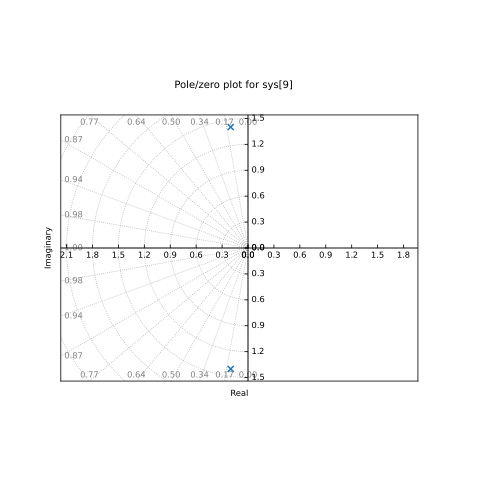

In [10]:
from matplotlib import pyplot as plt

# better plots in jupyter
%config InlineBackend.figure_formats = ['svg']

ct.pzmap(H, grid=True)
plt.show()


### What if we work with a discrete system ?

We have the same tools to find and draw the poles and to draw. Remember that for a discrete system, the stability condition is that the poles are located in a circle of unit radius centered at $(0,0)$.

In [11]:
Hz.poles()

array([0.97060841+0.13677998j, 0.97060841-0.13677998j])

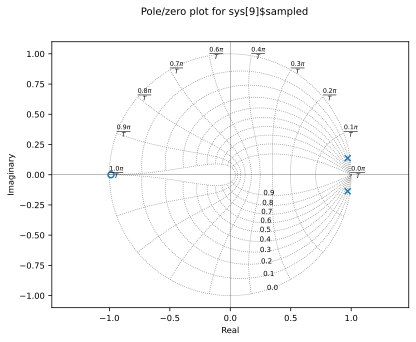

In [12]:
ct.pzmap(Hz, grid=True)
plt.show()

## Handling of LTI dynamic objects

When the output of the `H1` system is connected to the input of the `H2` system, the global transfer function is obtained by the series connection, thus mathematically by a multiplication of the 2 transfer functions.

In the time domain, the convolution integral should have been used instead of this simple product in the Laplace domain.

![](./12_image2.png)

In [13]:
assert s is not None

H5 = 1 / (5*s + 1)
H6=1 / (10*s + 1)
H5 * H6

TransferFunction(array([1]), array([50, 15,  1]))

... their parallelism is obtained with the " + ":

![](./12_image3.png)

In [14]:
H5 + H6

TransferFunction(array([15,  2]), array([50, 15,  1]))

When a feedback loop is closed, the Matlab feedback command is used to obtain the transfer function of the looped system:

![](./12_image4.png)

In [15]:
ct.feedback(H5, H6)

TransferFunction(array([10,  1]), array([50, 15,  2]))

or without the feedback function :

In [16]:
H5 / (1 + H5*H6)

TransferFunction(array([50, 15,  1]), array([250, 125,  25,   2]))

When manipulating these transfer functions, Matlab does not simplify the poles and zeros on its own initiative when possible.

In [17]:
assert s is not None
H2 = (s + 2) / ((s + 3) * (s + 5));
H3 = (s + 3) / (s + 4);
H3 * H2

TransferFunction(array([1, 5, 6]), array([ 1, 12, 47, 60]))

This often occurs when multiple operations are performed on transfer functions. We can therefore simplify the expression, which is done with the `ct.minreal` function:

In [18]:
ct.minreal(H3*H2)

1 states have been removed from the model


TransferFunction(array([1., 2.]), array([ 1.,  9., 20.]))

© JM Rousseau - D Rouchard - Q Lurkin